<span style="color:#800080;font-size: 3em;">Gender Classfication Using Deep Learning</span>



## <span style="color:#ffa500;font-size: 1em;">Introduction</span>
<span style="color:#008080;font-size: 1.5em;">Gender classification is an essential task in computer vision that aims to identify the gender of individuals in images. This has various applications, including user profiling, human-computer interaction, security systems, and targeted advertising. In this notebook, we will create a gender classification model using deep learning with TensorFlow and Keras. Our model will classify images into two categories: Male and Female.
</span>
## <span style="color:#ffa500;font-size: 1em;">Dataset</span>
<span style="color:#008080;font-size: 1.5em;">For this project, we will use a dataset containing images of male and female faces. The dataset is structured into separate directories for training and validation. Each directory contains subdirectories named 'Male' and 'Female' with respective images. This organization allows for easy loading and labeling of the data using TensorFlow's `image_dataset_from_directory` function.</span>

<span style="color:#1f77b4;font-size: 3em;">Import Library</span>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import BinaryCrossentropy
import warnings
warnings.filterwarnings('ignore')

2024-07-28 10:14:25.467692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 10:14:25.467793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 10:14:25.599078: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<span style="color:#1f77b4;font-size: 3em;">Load The Data</span>

In [2]:
train_directory = "/kaggle/input/gender-classification-dataset/Training"
val_directory = "/kaggle/input/gender-classification-dataset/Validation"

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 48,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 50,
    "DROPOUT_RATE": 0.05,
    "REGULARIZATION_RATE": 0.001,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 2,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ['female','male']
}

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 47009 files belonging to 2 classes.


In [5]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 11649 files belonging to 2 classes.


<span style="color:#1f77b4;font-size: 3em;">Visualize The Data

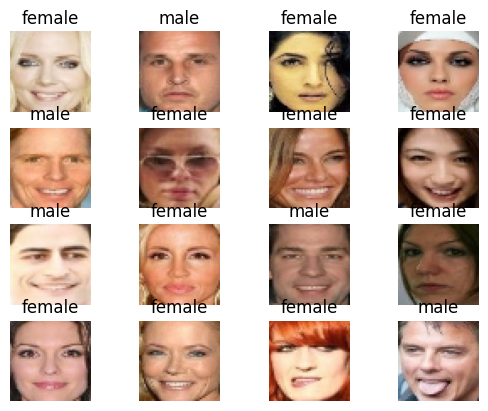

In [6]:

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

<span style="color:#1f77b4;font-size: 3em;">Preprocess The Data</span>

In [7]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE))

In [8]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),                 
])

<span style="color:#1f77b4;font-size: 3em;">Build the Model</span>

In [10]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "sigmoid"),

])



<span style="color:#1f77b4;font-size: 3em;">Model Summary</span>

In [11]:
lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 46, 46, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,776,626 (6.78 MB)

 Trainable params: 1,774,278 (6.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

<span style="color:#1f77b4;font-size: 3em;">Train The Model</span>

In [12]:
loss_function = BinaryCrossentropy()

In [13]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=4, name = "top_k_accuracy")]

In [14]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= CONFIGURATION["BATCH_SIZE"],

  epochs = CONFIGURATION["N_EPOCHS"],callbacks=[early_stopping],
  verbose = 1
)

Epoch 1/50


2024-07-28 10:15:55.227032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.87913, expected 6.06884
2024-07-28 10:15:55.227088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.19596, expected 4.38567
2024-07-28 10:15:55.227098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.9744, expected 5.16411
2024-07-28 10:15:55.227107: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.50678, expected 5.69649
2024-07-28 10:15:55.227114: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 23: 6.80629, expected 5.996
2024-07-28 10:15:55.227122: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 25: 7.01874, expected 6.20845
2024-07-28 10:15:55.227130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.80312, expected 5.99282
2024-07-28 10:15:55.227138: E external/local_xla/xla/s

  10/1470 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6905 - loss: 2.2056 - top_k_accuracy: 1.0000

I0000 00:00:1722161759.863288      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1470/1470 ━━━━━━━━━━━━━━━━━━━━ 80s 48ms/step - accuracy: 0.8842 - loss: 1.0430 - top_k_accuracy: 1.0000 - val_accuracy: 0.9014 - val_loss: 0.4072 - val_top_k_accuracy: 1.0000
Epoch 2/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9219 - loss: 0.3628 - top_k_accuracy: 1.0000 - val_accuracy: 0.9334 - val_loss: 0.3221 - val_top_k_accuracy: 1.0000
Epoch 3/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9293 - loss: 0.3350 - top_k_accuracy: 1.0000 - val_accuracy: 0.9436 - val_loss: 0.2840 - val_top_k_accuracy: 1.0000
Epoch 4/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9344 - loss: 0.2994 - top_k_accuracy: 1.0000 - val_accuracy: 0.9332 - val_loss: 0.2876 - val_top_k_accuracy: 1.0000
Epoch 5/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9380 - loss: 0.2776 - top_k_accuracy: 1.0000 - val_accuracy: 0.9190 - val_loss: 0.2957 - val_top_k_accuracy: 1.0000
Epoch 6/50
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.9400 - loss

<span style="color:#1f77b4;font-size: 3em;">Visualize The Model Loss</span>

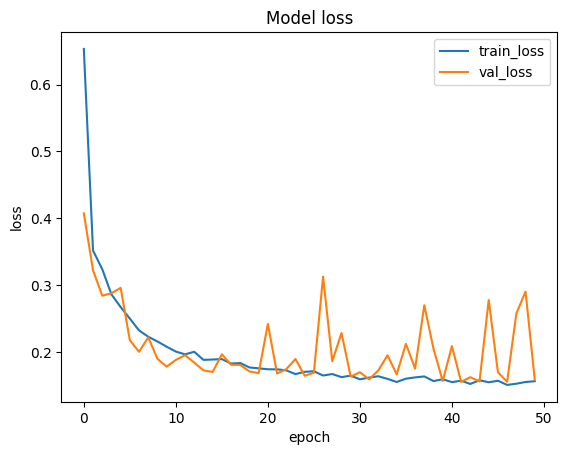

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

<span style="color:#1f77b4;font-size: 3em;">Visualize The Model Accuracy</span>

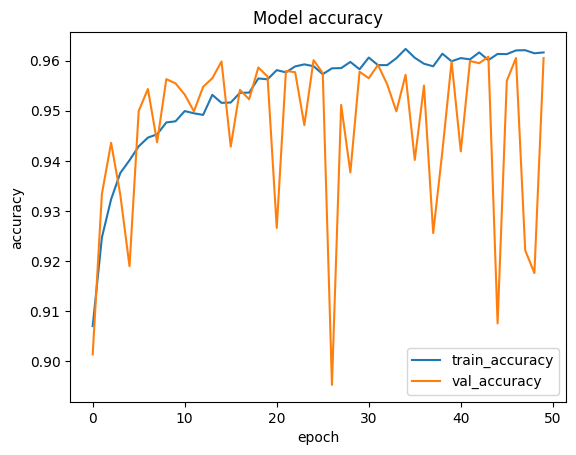

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

<span style="color:#1f77b4;font-size: 3em;">Save The Model</span>

In [19]:
lenet_model.save('gender_classification.h5')

<span style="color:#1f77b4;font-size: 3em;">Evalute The Model</span>

In [20]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import load_model
import numpy as np

In [21]:
model=load_model('/kaggle/working/gender_classification.h5')

In [22]:
img_path='/kaggle/input/gender-classification-dataset/Training/male/090553.jpg.jpg'

In [23]:
def male_or_female(img_path,model):
    img=load_img(img_path,target_size=(70,80))
    img_array=img_to_array(img)
    img_array=img_array/255.0
    new_array_with_batch_dimension=np.expand_dims(img_array,axis=0)
    output=model.predict(new_array_with_batch_dimension)
    output=np.round(output.flatten())[0]
    val="Male" if output==1 else 'Female'
    return val

In [24]:
male_or_female(img_path,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


'Female'